In [ ]:
#skeleton from https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8?gi=31a54e235615
#was used to model GAN
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS188CV/Final'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))



Mounted at /content/drive
['images', 'Untitled1.ipynb', 'DeepLearningExploration.ipynb', 'Untitled2.ipynb', 'FacialAttributeExtractor.ipynb', 'mxnet-face', 'data_processing.ipynb', 'colab-sg2-ada-pytorch', 'pixelGAN_clone.ipynb', 'utils.py']


In [ ]:

paths = glob.glob("/content/drive/My Drive/CS188CV/Final/images/formatted/*.png") # All paths to COCO dataset images
np.random.seed(123) # Seeding for reproducible results
paths_subset = np.random.choice(paths, 1000, replace=False) # Randomly choosing 10,000 images
rand_idxs = np.random.permutation(1000) # Shuffling the indexes
train_idxs = rand_idxs[:800] # Using first 8000 images for training
val_idxs = rand_idxs[800:] # Using last 2000 images for validating
train_paths = paths_subset[train_idxs] 
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

800 200


In [ ]:

SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
50 13


In [ ]:

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
print(PatchDiscriminator(input_c=3))      



PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:

discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape


torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net


def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
import time
from torchvision.utils import save_image
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

import torch


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count


def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}


def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(4):
        print(L[i][0].cpu().shape)
        save_image(L[i][0], f'/content/drive/My Drive/CS188CV/Final/images/STYLEGAN_image{i}.png')
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        #ax.figure.savefig('/content/drive/My Drive/CS188CV/Final/images/demo-file.png')
        ax.axis("off")
 
        # ax = plt.subplot(3, 5, i + 1 + 5)
        # ax.imshow(fake_imgs[i])
        # ax.axis("off")
        # ax = plt.subplot(3, 5, i + 1 + 10)
        # ax.imshow(real_imgs[i])
        # ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f'/content/drive/My Drive/CS188CV/Final/images/colorization_{time.time()}.png')


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


In [ ]:

def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs
     
train_model(model, train_dl, 100)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/CS188CV/Final/PixelGAN.pth")

model initialized with norm initialization
model initialized with norm initialization
[[[0.998279 0.999893 1.      ]
  [0.996285 1.       1.      ]
  [0.997671 1.       1.      ]
  [0.998766 1.       1.      ]
  ...
  [0.997195 1.       1.      ]
  [1.       0.999976 0.997468]
  [1.       0.997895 1.      ]
  [1.       1.       0.985254]]

 [[1.       0.99796  1.      ]
  [1.       0.99838  1.      ]
  [1.       0.999641 1.      ]
  [1.       0.998738 1.      ]
  ...
  [0.997669 1.       0.997997]
  [1.       0.999071 1.      ]
  [1.       0.998045 1.      ]
  [0.999672 1.       0.998375]]

 [[1.       0.999331 0.994939]
  [1.       0.998412 1.      ]
  [1.       1.       0.997871]
  [0.998071 1.       0.999248]
  ...
  [0.995172 1.       1.      ]
  [1.       0.998608 0.999716]
  [0.99826  1.       0.997362]
  [0.9979   1.       0.999135]]

 [[1.       0.999185 0.997821]
  [1.       0.999185 1.      ]
  [0.996402 1.       0.998809]
  [1.       0.999211 0.998542]
  ...
  [1.       0.99

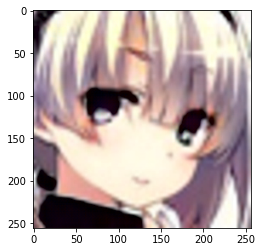

In [ ]:
import PIL
import torch
from matplotlib import pyplot as plt
from torchvision import transforms

model = MainModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(
    torch.load(
        "/content/drive/My Drive/CS188CV/Final/PixelGAN.pth",
        map_location=device
    )
)
for i in range(5):
  path = f'/content/drive/My Drive/CS188CV/Final/images/image{i}.png'
  img = PIL.Image.open(path)
  img = img.resize((256, 256))
  # to make it between -1 and 1
  img = transforms.ToTensor()(img)[:1] * 2. - 1.
  model.eval()
  with torch.no_grad():
      preds = model.net_G(img.unsqueeze(0).to(device))
  colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
  plt.imshow(colorized)

  # save_image(colorized, f'/content/drive/My Drive/CS188CV/Final/images/color_image{i}.png')
  plt.imsave(f'/content/drive/My Drive/CS188CV/Final/images/color_image{i}.png', colorized)

torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


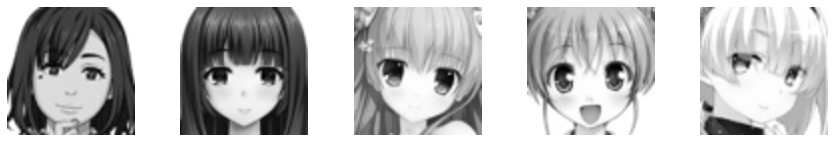

In [ ]:
 visualize(model, data, save=True)

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G



In [ ]:
paths = glob.glob("/content/drive/My Drive/CS188CV/Final/images/lab/*.png") # All paths to COCO dataset images
np.random.seed(123) # Seeding for reproducible results
paths_subset = np.random.choice(paths, 4, replace=False) # Randomly choosing 10,000 images
rand_idxs = np.random.permutation(1000) # Shuffling the indexes



In [ ]:
test_dl = make_dataloaders(paths=paths_subset, split='train')

data = next(iter(test_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 256, 256])
50 13


model initialized with norm initialization
model initialized with norm initialization
[[[0.998279 0.999893 1.      ]
  [0.996285 1.       1.      ]
  [0.997671 1.       1.      ]
  [0.998766 1.       1.      ]
  ...
  [0.997195 1.       1.      ]
  [1.       0.999976 0.997468]
  [1.       0.997895 1.      ]
  [1.       1.       0.985254]]

 [[1.       0.99796  1.      ]
  [1.       0.99838  1.      ]
  [1.       0.999641 1.      ]
  [1.       0.998738 1.      ]
  ...
  [0.997669 1.       0.997997]
  [1.       0.999071 1.      ]
  [1.       0.998045 1.      ]
  [0.999672 1.       0.998375]]

 [[1.       0.999331 0.994939]
  [1.       0.998412 1.      ]
  [1.       1.       0.997871]
  [0.998071 1.       0.999248]
  ...
  [0.995172 1.       1.      ]
  [1.       0.998608 0.999716]
  [0.99826  1.       0.997362]
  [0.9979   1.       0.999135]]

 [[1.       0.999185 0.997821]
  [1.       0.999185 1.      ]
  [0.996402 1.       0.998809]
  [1.       0.999211 0.998542]
  ...
  [1.       0.99

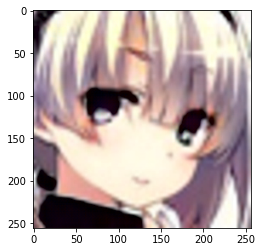

In [ ]:

model = MainModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(
    torch.load(
        "/content/drive/My Drive/CS188CV/Final/PixelGAN.pth",
        map_location=device
    )
)
for i in range(5):
  path = f'/content/drive/My Drive/CS188CV/Final/images/image{i}.png'
  img = PIL.Image.open(path)
  img = img.resize((256, 256))
  # to make it between -1 and 1
  img = transforms.ToTensor()(img)[:1] * 2. - 1.
  model.eval()
  with torch.no_grad():
      preds = model.net_G(img.unsqueeze(0).to(device))
  colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
  plt.imshow(colorized)

  print(colorized)
  # save_image(colorized, f'/content/drive/My Drive/CS188CV/Final/images/color_image{i}.png')
  plt.imsave(f'/content/drive/My Drive/CS188CV/Final/images/color_image{i}.png', colorized)

torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


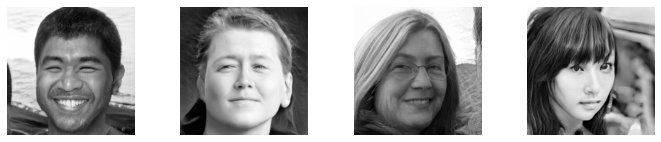

In [ ]:
 visualize(model, data, save=False)

model initialized with norm initialization
model initialized with norm initialization
[[[8.011569e-01 7.883922e-01 7.800556e-01]
  [8.907622e-01 8.697829e-01 8.418280e-01]
  [8.757752e-01 8.632501e-01 8.307938e-01]
  [9.053302e-01 8.838145e-01 8.397864e-01]
  ...
  [8.142901e-01 7.565272e-01 7.561567e-01]
  [7.926213e-01 7.514628e-01 7.560033e-01]
  [7.967809e-01 7.273005e-01 7.426208e-01]
  [7.207212e-01 6.816418e-01 6.709253e-01]]

 [[9.219256e-01 8.955018e-01 8.563039e-01]
  [9.229327e-01 9.067838e-01 8.633549e-01]
  [9.302167e-01 8.989599e-01 8.575022e-01]
  [9.348249e-01 9.092782e-01 8.633217e-01]
  ...
  [8.411053e-01 7.756779e-01 7.805543e-01]
  [8.398716e-01 7.585577e-01 7.722527e-01]
  [8.175789e-01 7.481360e-01 7.680467e-01]
  [8.056880e-01 7.524491e-01 7.642449e-01]]

 [[9.252465e-01 9.233692e-01 8.746978e-01]
  [9.398619e-01 9.191522e-01 8.725730e-01]
  [9.523403e-01 9.157593e-01 8.675586e-01]
  [9.453115e-01 9.179707e-01 8.672990e-01]
  ...
  [8.237991e-01 7.806971e-01 7.8

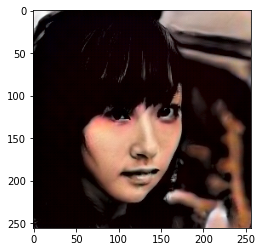

In [ ]:
model = MainModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(
    torch.load(
        "/content/drive/My Drive/CS188CV/Final/PixelGAN.pth",
        map_location=device
    )
)
for i in range(4):
  path = f'/content/drive/My Drive/CS188CV/Final/images/STYLEGAN_image{i}.png'
  img = PIL.Image.open(path)
  img = img.resize((256, 256))
  # to make it between -1 and 1
  img = transforms.ToTensor()(img)[:1] * 2. - 1.
  model.eval()
  with torch.no_grad():
      preds = model.net_G(img.unsqueeze(0).to(device))
  colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
  plt.imshow(colorized)

  print(colorized)
  # save_image(colorized, f'/content/drive/My Drive/CS188CV/Final/images/color_image{i}.png')
  plt.imsave(f'/content/drive/My Drive/CS188CV/Final/images/stylGAN_color_image{i}.png', colorized)